Customer segmentation of OLIST using K-Prototype clustering
=================

### A ecommerce company plans to analyze customer purchasing behavior to identify distinct customer segments and tailor marketing strategies specifically for each group. This involves categorizing customers based on their buying patterns and preferences to enhance targeted marketing and improve overall business outcomes.

This we will do with the use of a KPrototype algorithm.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


In [2]:
# Install kprototype
!pip install kmodes

In [3]:
import seaborn as sns
from scipy import stats
from datetime import date,timedelta,datetime
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

In [4]:
customer = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
order = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
item = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
payment = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')

In [5]:
# Merge the 'customer' and 'order' datasets on the 'customer_id' column
# Keeps only rows with matching 'customer_id' in both datasets (inner join)
df = customer.merge(order, how='inner', on='customer_id')

# Merge the resulting DataFrame with the 'item' dataset on the 'order_id' column
# Keeps only rows with matching 'order_id' in both datasets (inner join)
df = df.merge(item, how='inner', on='order_id')

# Merge the resulting DataFrame with the 'payment' dataset on the 'order_id' column
# Keeps only rows with matching 'order_id' in both datasets (inner join)
df = df.merge(payment, how='inner', on='order_id')

In [6]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,credit_card,8,252.25


In [7]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [8]:
df.duplicated().sum()

0

In [9]:
#Only consider the order_status which are delivered
df= df.loc[df.order_status=='delivered']

In [10]:
date_columns = ['order_purchase_timestamp','order_approved_at', 
                'order_delivered_carrier_date','order_delivered_customer_date', 
                'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
payment_sequential                        int64
payment_type                             object
payment_installments                    

In [11]:
# Create a new dataset
df = df[['customer_unique_id', 'order_id', 'payment_type', 'order_delivered_carrier_date', 
         'order_purchase_timestamp' ,'order_approved_at', 'payment_value']]

In [12]:
df.isna().sum().sort_values(ascending=False)

order_approved_at               15
order_delivered_carrier_date     2
customer_unique_id               0
order_id                         0
payment_type                     0
order_purchase_timestamp         0
payment_value                    0
dtype: int64

In [13]:
# Drop the NaN values
df=df.dropna()

In [14]:
df.isna().sum()

customer_unique_id              0
order_id                        0
payment_type                    0
order_delivered_carrier_date    0
order_purchase_timestamp        0
order_approved_at               0
payment_value                   0
dtype: int64

**K-Prototype clustering**

K-Prototype is a clustering method based on partitioning. The algorithm is an improvement of the K-Means and K-Mode clustering algorithm to handle clustering with mixed data types.

The RFM dataset is typically used in marketing and customer relationship management (CRM) to analyze customer behavior and segment customers based on three key factors:

Recency (R): How recently a customer made a purchase.
This measures the time interval (e.g., days or months) between the customer's last purchase and a specific reference date (usually today). A smaller value indicates a more recent purchase.

Frequency (F): How often a customer makes purchases.
This counts the total number of purchases a customer made during a specified period. A higher frequency indicates a more loyal or engaged customer.

Monetary (M): How much money a customer spends.
This is the total revenue or spending generated by a customer during the specified period. Higher monetary values indicate more valuable customers.

In [15]:
# Create the RFM dataset with categorical data
last_date = df['order_delivered_carrier_date'].max() + timedelta(days=1)
RFM = df.groupby(['customer_unique_id', 'payment_type']).agg({
    'order_delivered_carrier_date': lambda x: (last_date - x.max()).days,
    'order_id': lambda x: len(x),
    'payment_value': 'sum'
})

In [16]:
# Reset the index
RFM.reset_index(inplace=True)

In [17]:
# Rename the columns
RFM.columns=['customer_unique_id', 'payment_type', 'Recency', 'Frequency', 'MonetaryValue']
RFM.head()

,customer_unique_id,payment_type,Recency,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,credit_card,123,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card,126,1,27.19
2,0000f46a3911fa3c0805444483337064,credit_card,548,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,credit_card,333,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,credit_card,299,1,196.89


In [18]:
#lets check the different type of payment method
RFM.payment_type.unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card'], dtype=object)

In [19]:
# Remove the outlies from the monetary value
q1_mv = RFM['MonetaryValue'].quantile(0.25)
q3_mv = RFM['MonetaryValue'].quantile(0.75)
IQR = q3_mv - q1_mv
RFM = RFM[(RFM['MonetaryValue'] > q1_mv - 1.5*IQR) & (RFM['MonetaryValue'] < q3_mv + 1.5*IQR)]

In [20]:
# Check for missing values
RFM.isnull().sum()

customer_unique_id    0
payment_type          0
Recency               0
Frequency             0
MonetaryValue         0
dtype: int64

In [21]:
for c in RFM.select_dtypes(exclude='object').columns:
    std = StandardScaler()
    RFM[c] =  std.fit_transform(np.array(RFM[c]).reshape(-1, 1))

In [22]:
# In the kmeans algorithm we saw 6 is the optimal number of clusters
kproto = KPrototypes(n_clusters= 6, init='Cao', n_jobs = -1)
kcluster = kproto.fit(RFM, categorical=[0, 1])

In [23]:
#check how the labels are distributed
labels = kcluster.labels_
pd.Series(labels).value_counts()

1    24937
0    24077
4    16718
5    13511
2     6293
3      952
Name: count, dtype: int64

In [24]:
# Create a new dataframe
last_date = df['order_delivered_carrier_date'].max() + timedelta(days=1)
RFMP1 = df.groupby(['customer_unique_id', 'payment_type']).agg({
    'order_delivered_carrier_date': lambda x: (last_date - x.max()).days,
    'order_id': lambda x: len(x),
    'payment_value': 'sum'
})

In [25]:
RFMP1.reset_index(inplace=True)
RFMP1.shape

(95789, 5)

In [26]:
RFMP1.columns

Index(['customer_unique_id', 'payment_type', 'order_delivered_carrier_date',
       'order_id', 'payment_value'],
      dtype='object')

In [27]:
RFMP1.head()

,customer_unique_id,payment_type,order_delivered_carrier_date,order_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,credit_card,123,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card,126,1,27.19
2,0000f46a3911fa3c0805444483337064,credit_card,548,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,credit_card,333,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,credit_card,299,1,196.89


In [28]:
RFMP1.columns=['customer_unique_id','payment_type', 'Recency', 'Frequency', 'MonetaryValue']
RFMP1.head()

,customer_unique_id,payment_type,Recency,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,credit_card,123,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card,126,1,27.19
2,0000f46a3911fa3c0805444483337064,credit_card,548,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,credit_card,333,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,credit_card,299,1,196.89


In [29]:
q1_mv = RFMP1['MonetaryValue'].quantile(0.25)
q3_mv = RFMP1['MonetaryValue'].quantile(0.75)
IQR = q3_mv - q1_mv
RFMP1 = RFMP1[(RFMP1['MonetaryValue'] > q1_mv - 1.5*IQR) & (RFMP1['MonetaryValue'] < q3_mv + 1.5*IQR)]

In [30]:
RFMP1.shape

(86488, 5)

In [31]:
RFM.shape

(86488, 5)

In [32]:
RFMP1['kpcluster']= kcluster.labels_

In [33]:
RFMP1.head()

,customer_unique_id,payment_type,Recency,Frequency,MonetaryValue,kpcluster
0,0000366f3b9a7992bf8c76cfdf3221e2,credit_card,123,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,credit_card,126,1,27.19,1
2,0000f46a3911fa3c0805444483337064,credit_card,548,1,86.22,4
3,0000f6ccb0745a6a4b88665a16c9f078,credit_card,333,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,credit_card,299,1,196.89,5


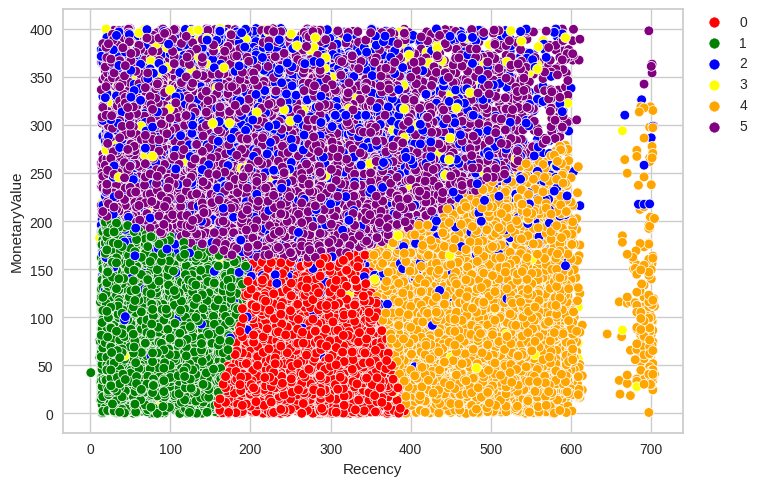

In [34]:
sns.scatterplot(x='Recency', y='MonetaryValue', hue= 'kpcluster', data=RFMP1,
                palette=['red', 'green', 'blue', 'yellow', 'orange', 'purple'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [35]:
RFMP2= RFMP1.drop(columns=['customer_unique_id', 'payment_type', 'kpcluster'])

In [36]:
RFMP2_std = std.fit_transform(RFMP2)

In [37]:
kproto_score = silhouette_score(RFMP2_std, kcluster.labels_, metric='euclidean')
print("Silhouette Score for the k-prototype clustering:", round(kproto_score, 4))

Silhouette Score for the k-prototype clustering: 0.3431


In [38]:
db_score = davies_bouldin_score(RFMP2_std, kcluster.labels_)
print(f"Davies-Bouldin Index: {db_score}")

Davies-Bouldin Index: 1.017079824237509


#### PCA  for K-Prototype

In [39]:
pca=PCA(n_components=2)
principal_comp=pca.fit_transform(RFMP2_std)
principal_comp

array([[ 0.01327361, -0.85096486],
       [-0.95379695, -0.76684598],
       [-0.47680378,  1.962916  ],
       ...,
       [-0.2572291 ,  2.16422626],
       [-0.05636997, -0.78742481],
       [-0.59784031,  1.6306989 ]])

In [40]:
pca_df=pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,0.013274,-0.850965
1,-0.953797,-0.766846
2,-0.476804,1.962916
3,-0.825403,0.579201
4,0.468214,0.270443


In [41]:
pca_df=pd.concat([pca_df, RFMP1['kpcluster']], axis=1)
pca_df.head()

,pca1,pca2,kpcluster
0,0.013274,-0.850965,1.0
1,-0.953797,-0.766846,1.0
2,-0.476804,1.962916,4.0
3,-0.825403,0.579201,0.0
4,0.468214,0.270443,5.0


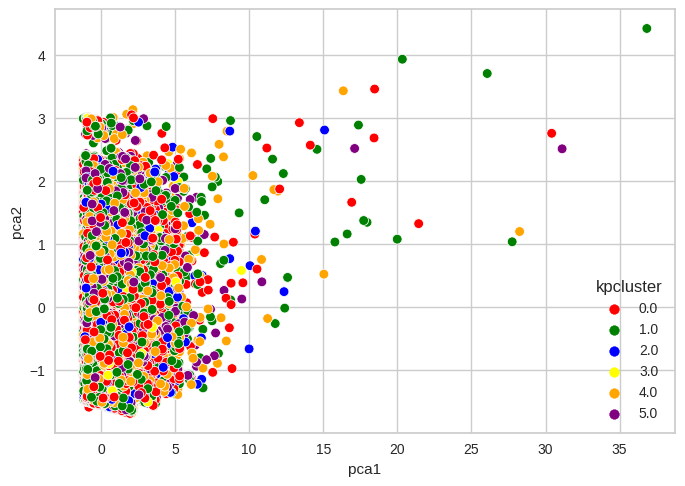

In [42]:
sns.scatterplot(x='pca1', y='pca2', hue='kpcluster', data=pca_df, 
                palette=['red', 'green', 'blue', 'yellow','orange','purple'])
plt.show()

#### TSNE for KPrototype

In [43]:
tsne=TSNE(n_components=2, init='pca', perplexity= 35, random_state=42, learning_rate='auto')

In [44]:
tsne=tsne.fit_transform(RFMP2_std)

In [45]:
tsne_df=pd.DataFrame(data=tsne, columns=['tsne1','tsne2'])

In [46]:
tsne_df=pd.concat([tsne_df, RFMP1['kpcluster']], axis=1)
tsne_df.head()

,tsne1,tsne2,kpcluster
0,27.883862,-60.058643,1.0
1,-107.680519,-65.280975,1.0
2,12.658979,120.720375,4.0
3,-79.787827,56.758476,0.0
4,51.950287,26.853859,5.0


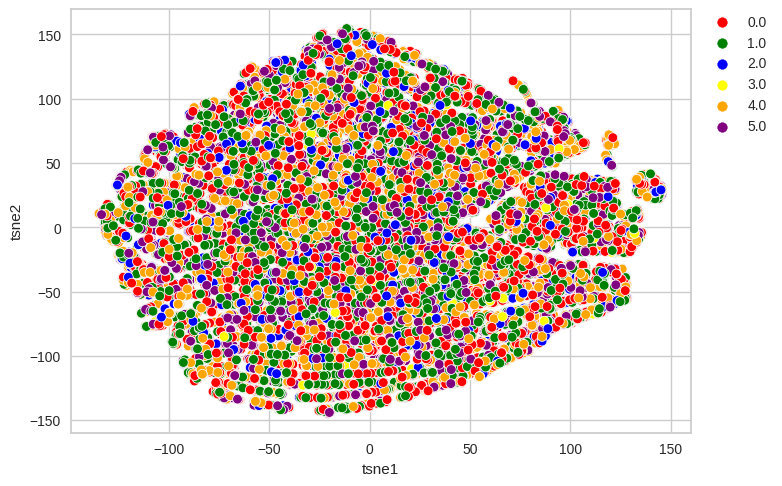

In [47]:
sns.scatterplot(x='tsne1', y='tsne2', hue='kpcluster', data=tsne_df, 
                palette=['red', 'green', 'blue', 'yellow','orange','purple'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

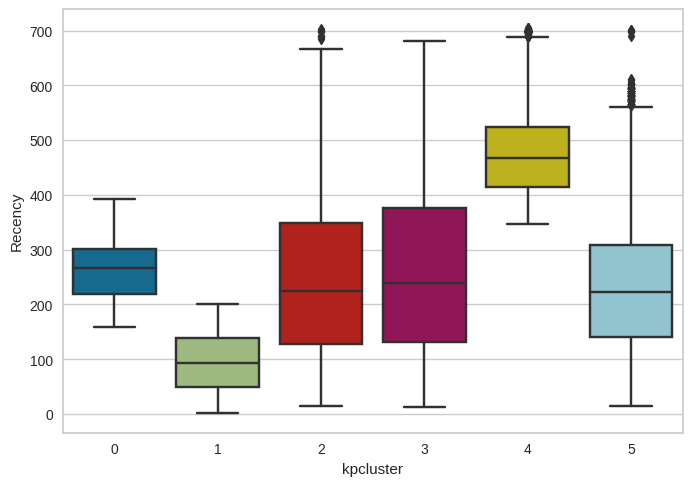

In [48]:
# Create a box plot to visualize the distribution of 'Recency' values across different clusters
sns.boxplot(x='kpcluster', y='Recency', data=RFMP1);

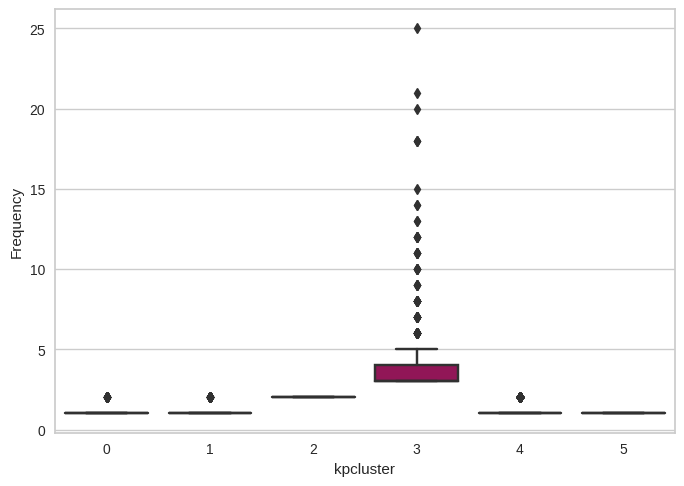

In [49]:
# Create a box plot to visualize the distribution of 'Frequency' values across different clusters
sns.boxplot(x='kpcluster', y='Frequency', data=RFMP1);

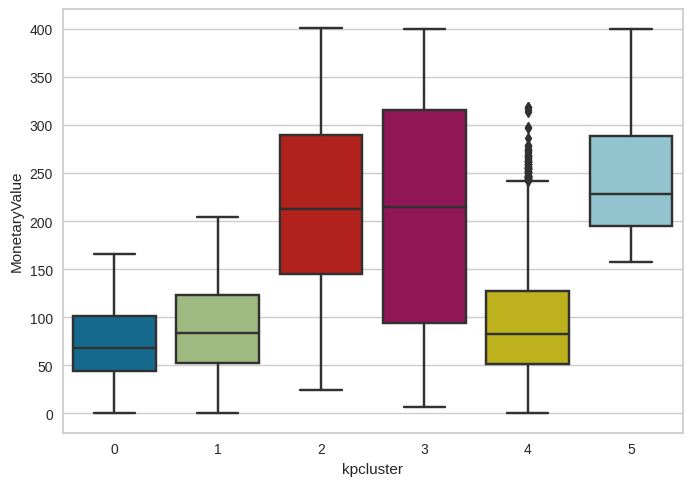

In [50]:
# Create a box plot to visualize the distribution of 'Monetary' values across different clusters
sns.boxplot(x='kpcluster', y='MonetaryValue', data=RFMP1);

The visualization helps in:

- Comparing how monetary spending varies across different clusters.
- Identifying clusters with high or low monetary spending.
- Spotting clusters with significant outliers or skewed distributions.
- Informing targeted marketing strategies based on spending patterns.